In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.integrate
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.signal as signal
import random
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import utils
import h5py
import time
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
def fit_func(x, A, B, tau_1, tau_2):
    return A*np.exp(-(x)/tau_1) +B*np.exp(-(x)/tau_2)



def get_channel_2(data):
    
    data=np.asarray(data)
    digitizer_arrays=[]

    for val in data:
        digitizer_arrays.append(val[3][:8192])
    
    
    digitizer_channel_2=[]
    for array in digitizer_arrays:
        pedestal=array[2048]
        digitizer_channel_2.append(-array[2048:3072]+pedestal)
    
    digitizer_channel_2=np.asarray(digitizer_channel_2)
    return digitizer_channel_2


def channel_2_cleaning(digitizer_channel_2):
    digitizer_channel_2_cut=[]
    half_max_index=[]
    for array in digitizer_channel_2:
        max_val=np.max(array)
        max_val_index=array.argmax()
        half_val=max_val/2
        try:
            idx = (np.abs(array[:max_val_index] - half_val)).argmin()
            if idx < 200 and (np.abs(max_val_index-idx)<15) and (max_val>0.05):
                half_max_index.append(idx)
                digitizer_channel_2_cut.append(array)
        except ValueError:
            pass

    digitizer_channel_2_cut=np.asarray(digitizer_channel_2_cut)
    
    return digitizer_channel_2_cut, half_max_index


def channel_2_aligning(digitizer_channel_2_cut, half_max_index):
    cut_vals=[]
    min_of_half_max=min(half_max_index)
    for i in half_max_index:
        cut_vals.append(i-min_of_half_max)
    
    aligned_digitizer_channel_2_cut=[]
    lengths=[]
    
    for i in range(len(digitizer_channel_2_cut)):
        lengths.append(len(digitizer_channel_2_cut[i][cut_vals[i]:]))
    
    
    min_length=min(lengths)
    
    
    
    for i in range(len(digitizer_channel_2_cut)):
        assert len(digitizer_channel_2_cut)==len(cut_vals)
        array=digitizer_channel_2_cut[i][cut_vals[i]:cut_vals[i]+min_length]
        aligned_digitizer_channel_2_cut.append(array[:])
    
    aligned_digitizer_channel_2_cut=np.asarray(aligned_digitizer_channel_2_cut)
    return aligned_digitizer_channel_2_cut


def calculate_percentages(aligned_digitizer_channel_2_cut):
    dt=0.4
    aligned_digitizer_channel_2_cut_avg=np.mean(aligned_digitizer_channel_2_cut, axis=0)
    
    
    xdata=np.arange(0,len(aligned_digitizer_channel_2_cut_avg)*0.4,0.4)
    ydata=aligned_digitizer_channel_2_cut_avg
    popt, pcov = sp.optimize.curve_fit(fit_func, xdata[14:], ydata[14:] , p0=(0.26, 0.74,55,145))
    
    b=sp.integrate.trapz(ydata[14:], xdata[14:])
    c=sp.integrate.trapz(ydata, xdata)
    a=b/c
    
    
    
    adjusted_percentages=[]
    for array in aligned_digitizer_channel_2_cut:
    
        cerenkov=np.trapz(array[:14], dx=dt)
        scint=np.trapz(array[14:], dx=dt)
        
        
        
        adjusted_cerenkov=cerenkov-(scint*((1/a)-1))
        adjusted_scint=scint/a
        total=adjusted_cerenkov+adjusted_scint
        adjusted_percentages.append([adjusted_cerenkov, adjusted_scint])
        
    adjusted_percentages=np.asarray(adjusted_percentages)
    return adjusted_percentages



def data_preprocessing(filename):
    file=h5py.File(filename,'r')
    data = file.get('data')
    digitizer_channel_2=get_channel_2(data)
    
    digitizer_channel_2_cut, half_max_index=channel_2_cleaning(digitizer_channel_2)
    
    
    aligned_digitizer_channel_2_cut=channel_2_aligning(digitizer_channel_2_cut, half_max_index)
    
    
    output_values=calculate_percentages(aligned_digitizer_channel_2_cut)
    
    
    return aligned_digitizer_channel_2_cut, output_values
    




    
    
        

In [3]:
aligned_digitizer_channel_2_cut, output_values=data_preprocessing('6292_skimTree.hdf5')

In [7]:
print(output_values)

[[ 0.21359943  7.59122576]
 [ 0.0410795   7.97126993]
 [-0.04655451  3.17664191]
 ...
 [-0.01701857  3.18208076]
 [-0.02674683  2.42975735]
 [-0.01672821  5.57656454]]


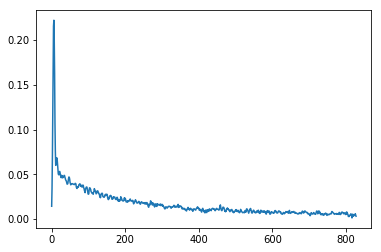

In [17]:
plt.plot(aligned_digitizer_channel_2_cut[75370])

In [19]:
file=h5py.File('D:\\Murali Backup\\Documents\\15-Cornell-3rd-year\\2nd-Semester\\Pulse_Generation_and_Neural_Net\\Workspace\\Dual_Readout_Calorimetry\\Real_Data\\beamline_data\\Real_Data\\6311_skimTree.hdf5','r')

In [20]:
aligned_digitizer_channel_2_cut_2, output_values_2=data_preprocessing('D:\\Murali Backup\\Documents\\15-Cornell-3rd-year\\2nd-Semester\\Pulse_Generation_and_Neural_Net\\Workspace\\Dual_Readout_Calorimetry\\Real_Data\\beamline_data\\Real_Data\\6311_skimTree.hdf5')

In [21]:
print(output_values_2)

[[-0.03029967  6.92699779]
 [-0.06180536  5.33222121]
 [-0.11257935  5.94336081]
 ...
 [-0.03624863  1.41440821]
 [-0.0622215   7.69218758]
 [-0.20768408  6.13294278]]


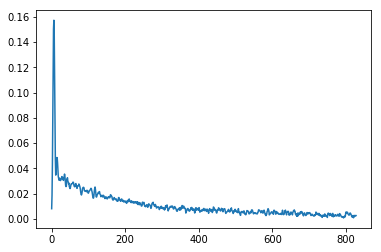

In [24]:
plt.plot(aligned_digitizer_channel_2_cut[7570])

In [25]:
file.close()

In [26]:
file.close()